In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
image_dir = "/kaggle/input/chomeo/images/images"
annotation_dir = "/kaggle/input/chomeo/annotations/annotations"
xml_dir = "/kaggle/input/chomeo/annotations/annotations/xmls"

trainval_txt = "/kaggle/input/chomeo/annotations/annotations/trainval.txt"
test_txt = "/kaggle/input/chomeo/annotations/annotations/test.txt"

def load_list(file_path, with_labels=False):
    image_list = []
    labels = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if not parts:
                continue
            image_name = parts[0] + ".jpg"
            image_list.append(image_name)
            if with_labels and len(parts) > 2:
                species = parts[2]
                if species not in ["1", "2"]:
                    print(f"Warning: Invalid species '{species}' for {image_name} in {file_path}")
                    continue
                labels.append(0 if species == "1" else 1)
                if image_name[0].isupper() and species != "1":
                    print(f"Warning: Image {image_name} starts with capital letter but species is {species}")
                elif image_name[0].islower() and species != "2":
                    print(f"Warning: Image {image_name} starts with lowercase letter but species is {species}")
    if with_labels:
        print(f"Loaded {len(image_list)} images and {len(labels)} labels from {file_path}")
        print("Label counts:", {0: labels.count(0), 1: labels.count(1)})
        return image_list, labels
    return image_list
trainval_images = load_list(trainval_txt)
test_images = load_list(test_txt)

print("Số ảnh train/val:", len(trainval_images))
print("Số ảnh test:", len(test_images))


Số ảnh train/val: 3680
Số ảnh test: 3669


In [4]:
def extract_hog_features(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    resized_image = cv2.resize(gray, (128, 128))

    hog_features = hog(
        resized_image,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        orientations=9,
        block_norm='L2-Hys',
        visualize=False
    )
    return hog_features

In [5]:
def visualize_hog(image, title='Biểu đồ hướng gradient (HOG)'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray, (128, 128))
    _, hog_image = hog(
        resized_image,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        orientations=9,
        block_norm='L2-Hys',
        visualize=True
    )

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Ảnh gốc')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

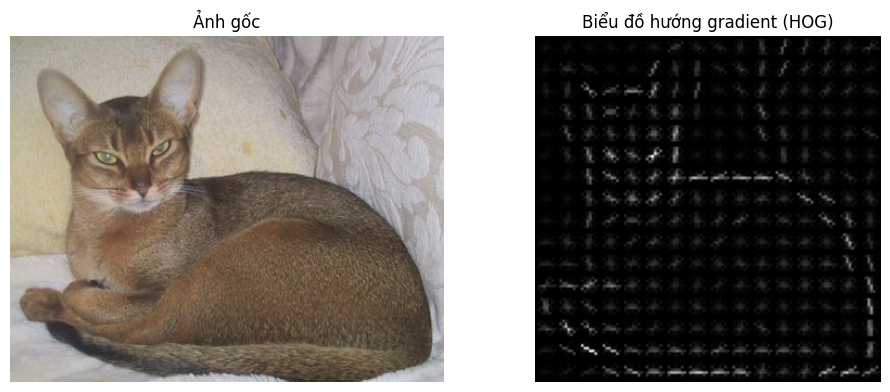

In [6]:
image = cv2.imread('/kaggle/input/chomeo/images/images/Abyssinian_110.jpg')  
visualize_hog(image)

In [7]:
cat_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.4),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

In [8]:
def prepare_data(image_names, image_dir, xml_dir=None, augment_cat_times=3, is_test=False, labels=None):
    features = []
    label_list = []
    bboxes = [] if not is_test else None

    for idx, image_name in enumerate(image_names):
        image_path = os.path.join(image_dir, image_name)
        if not os.path.exists(image_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue

        if is_test:
            if labels is None or idx >= len(labels):
                continue
            label = labels[idx]
            hog_features = extract_hog_features(image)
            features.append(hog_features)
            label_list.append(label)
            continue

        xml_path = os.path.join(xml_dir, image_name.replace(".jpg", ".xml"))
        if not os.path.exists(xml_path):
            continue

        tree = ET.parse(xml_path)
        root = tree.getroot()
        label = None
        bbox = None
        for obj in root.findall("object"):
            label = obj.find("name").text.lower()
            bbox_node = obj.find("bndbox")
            if bbox_node is not None:
                bbox = [
                    int(bbox_node.find("xmin").text),
                    int(bbox_node.find("ymin").text),
                    int(bbox_node.find("xmax").text),
                    int(bbox_node.find("ymax").text)
                ]
            break

        if label not in ["cat", "dog"]:
            continue

        norm_bbox = bbox

        if label == "cat":
            for _ in range(augment_cat_times):
                augmented = cat_augmentation(image=image, bboxes=[norm_bbox])
                aug_image = augmented["image"]
                aug_bbox = augmented["bboxes"][0] if augmented["bboxes"] else norm_bbox

                hog_features = extract_hog_features(aug_image)
                features.append(hog_features)
                label_list.append(0)
                bboxes.append(aug_bbox)

        hog_features = extract_hog_features(image)
        features.append(hog_features)
        label_list.append(0 if label == "cat" else 1)
        bboxes.append(bbox)

    if is_test:
        return np.array(features), np.array(label_list)
    return np.array(features), np.array(label_list), np.array(bboxes)

In [9]:
train_images, val_images = train_test_split(trainval_images, test_size=0.2, random_state=42)


X_train, y_train, bboxes_train = prepare_data(train_images, image_dir, xml_dir)
print("Shape of X_train before scaling:", X_train.shape)
print("Shape of bboxes_train:", bboxes_train.shape)

X_val, y_val, bboxes_val = prepare_data(val_images, image_dir, xml_dir)
print("Shape of X_val before scaling:", X_val.shape)
print("Shape of bboxes_val:", bboxes_val.shape)

test_images, test_labels = load_list(test_txt, with_labels=True)
X_test, y_test = prepare_data(test_images, image_dir, is_test=True, labels=test_labels)
print("Shape of X_test before scaling:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Shape of X_train after scaling:", X_train_scaled.shape)
print("Shape of X_val after scaling:", X_val_scaled.shape)
print("Shape of X_test after scaling:", X_test_scaled.shape)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Shape of X_train before scaling: (5720, 8100)
Shape of bboxes_train: (5720, 4)
Shape of X_val before scaling: (1494, 8100)
Shape of bboxes_val: (1494, 4)
Loaded 3669 images and 3669 labels from /kaggle/input/chomeo/annotations/annotations/test.txt
Label counts: {0: 1183, 1: 2486}
Shape of X_test before scaling: (3669, 8100)
Shape of X_train after scaling: (5720, 8100)
Shape of X_val after scaling: (1494, 8100)
Shape of X_test after scaling: (3669, 8100)


In [10]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.class_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

        self.bbox_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 4),
        )

    def forward(self, x):
        x = self.shared(x)
        class_logits = self.class_head(x)
        bbox_pred = self.bbox_head(x)
        return class_logits, bbox_pred

In [11]:
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long),
    torch.tensor(bboxes_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long),
    torch.tensor(bboxes_val, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [12]:
def compute_iou(pred_bbox, true_bbox):
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox


    x_left = max(pred_xmin, true_xmin)
    y_top = max(pred_ymin, true_ymin)
    x_right = min(pred_xmax, true_xmax)
    y_bottom = min(pred_ymax, true_ymax)

    if x_right < x_left or y_bottom < y_top:
        return 0.0


    intersection = (x_right - x_left) * (y_bottom - y_top)
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    true_area = (true_xmax - true_xmin) * (true_ymax - true_ymin)
    union = pred_area + true_area - intersection

    return intersection / union if union > 0 else 0.0

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss) 
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Epoch 1/150
- Avg Train Loss: 178.2575
- Class Loss: Avg = 0.1395
- Bbox Loss:  Avg = 178.1180
- Val IoU: 0.0000

Epoch 2/150
- Avg Train Loss: 177.8926
- Class Loss: Avg = 0.0954
- Bbox Loss:  Avg = 177.7972
- Val IoU: 0.0000

Epoch 3/150
- Avg Train Loss: 177.6173
- Class Loss: Avg = 0.0751
- Bbox Loss:  Avg = 177.5422
- Val IoU: 0.0000

Epoch 4/150
- Avg Train Loss: 177.3556
- Class Loss: Avg = 0.0597
- Bbox Loss:  Avg = 177.2959
- Val IoU: 0.0000

Epoch 5/150
- Avg Train Loss: 176.9183
- Class Loss: Avg = 0.0469
- Bbox Loss:  Avg = 176.8714
- Val IoU: 0.0000

Epoch 6/150
- Avg Train Loss: 176.7055
- Class Loss: Avg = 0.0375
- Bbox Loss:  Avg = 176.6680
- Val IoU: 0.0000

Epoch 7/150
- Avg Train Loss: 176.3739
- Class Loss: Avg = 0.0328
- Bbox Loss:  Avg = 176.3410
- Val IoU: 0.0000

Epoch 8/150
- Avg Train Loss: 176.2214
- Class Loss: Avg = 0.0252
- Bbox Loss:  Avg = 176.1962
- Val IoU: 0.0000

Epoch 9/150
- Avg Train Loss: 176.1259
- Class Loss: Avg = 0.0241
- Bbox Loss:  Avg = 17

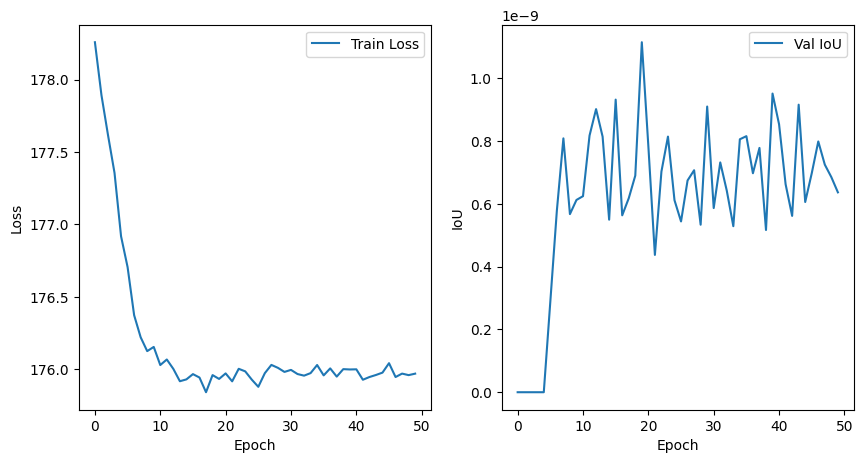

In [14]:
def evaluate_iou(bbox_preds, bbox_trues):
    total_iou = 0
    count = 0
    for pred, true in zip(bbox_preds, bbox_trues):
        iou = compute_iou(pred.cpu().tolist(), true.cpu().tolist())
        total_iou += iou
        count += 1
    return total_iou / count if count > 0 else 0.0

import torch.nn.functional as F
input_dim = X_train_scaled.shape[1]
model = MLPClassifier(input_dim).to(device)

class_criterion = FocalLoss(gamma=2.25)
bbox_criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=2e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

num_epochs = 150
best_val_iou = 0
bbox_loss_weight = 1
patience = 30
early_stop_counter = 0

train_losses = []
val_ious = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0

    for batch_X, batch_y, batch_bboxes in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device).long()  
        batch_bboxes = batch_bboxes.to(device)

        optimizer.zero_grad()
        class_logits, bbox_pred = model(batch_X)

        class_loss = class_criterion(class_logits, batch_y)
        bbox_loss = bbox_criterion(bbox_pred, batch_bboxes)
        loss = class_loss + bbox_loss_weight * bbox_loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_class_loss = total_class_loss / len(train_loader)
    avg_bbox_loss = total_bbox_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        val_bbox_preds = []
        val_bbox_trues = []
        for batch_X, batch_y, batch_bboxes in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).long()
            batch_bboxes = batch_bboxes.to(device)

            class_logits, bbox_pred = model(batch_X)
            val_bbox_preds.extend(bbox_pred)
            val_bbox_trues.extend(batch_bboxes)

        avg_val_iou = evaluate_iou(val_bbox_preds, val_bbox_trues)

    train_losses.append(avg_train_loss)
    val_ious.append(avg_val_iou)

    scheduler.step(1 - avg_val_iou)  # giảm lr khi val_iou không cải thiện

    print(f"""Epoch {epoch+1}/{num_epochs}
- Avg Train Loss: {avg_train_loss:.4f}
- Class Loss: Avg = {avg_class_loss:.4f}
- Bbox Loss:  Avg = {avg_bbox_loss:.4f}
- Val IoU: {avg_val_iou:.4f}
""")

    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

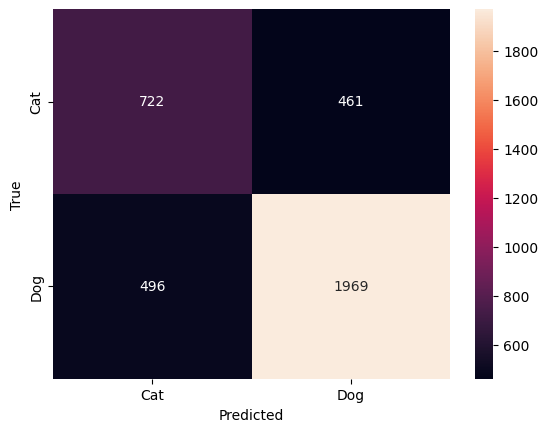

In [15]:
model.eval()
correct = 0
total = 0
total_iou = 0
num_bboxes = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        class_logits, bbox_pred = model(batch_X)
        _, predicted = torch.max(class_logits, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        class_logits, _ = model(batch_X)
        predicted = torch.argmax(class_logits, dim=1)

        y_pred.extend(predicted.cpu().tolist())
        y_true.extend(batch_y.cpu().tolist())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.59      0.61      0.60      1183
         Dog       0.81      0.80      0.80      2465

    accuracy                           0.74      3648
   macro avg       0.70      0.70      0.70      3648
weighted avg       0.74      0.74      0.74      3648



In [17]:
def predict_and_draw(image_name):
    image_path = os.path.join(image_dir, image_name)
    if not os.path.exists(image_path):
        print(f"Image {image_name} not found")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image {image_name}")
        return None

    # Extract and scale features
    hog_features = extract_hog_features(image)
    hog_features = scaler.transform([hog_features])
    hog_tensor = torch.tensor(hog_features, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        class_logits, bbox_pred = model(hog_tensor)
        label = torch.argmax(class_logits, dim=1).item()
        bbox = bbox_pred[0].tolist()  # Now in absolute pixel values

    height, width, _ = image.shape

    # Clamp to image size
    xmin = int(min(max(bbox[0], 0), width - 1))
    ymin = int(min(max(bbox[1], 0), height - 1))
    xmax = int(min(max(bbox[2], 0), width - 1))
    ymax = int(min(max(bbox[3], 0), height - 1))

    # Draw the bbox
    color = (0, 255, 0) if label == 0 else (255, 165, 0)
    label_name = "Cat" if label == 0 else "Dog"
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 4)
    cv2.putText(image, label_name, (xmin, max(ymin - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [18]:
def display_random_images(image_names, image_dir, num_samples=5):
    indices = np.random.choice(len(image_names), min(num_samples, len(image_names)), replace=False)
    plt.figure(figsize=(15, 3 * num_samples))

    for i, idx in enumerate(indices):
        image_name = image_names[idx]
        result_image = predict_and_draw(image_name)
        if result_image is not None:
            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(result_image)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

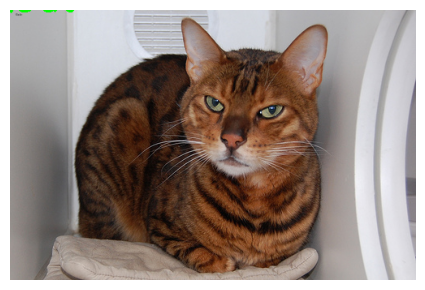

In [19]:
# Gọi hàm display_random_images
display_random_images(test_images, image_dir, num_samples=1)

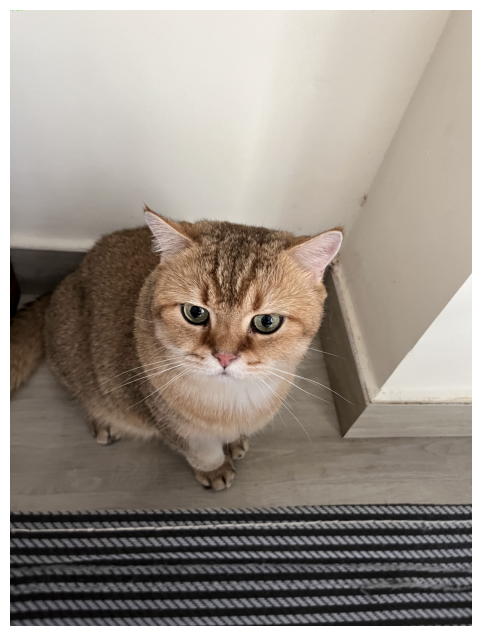

In [20]:
result_image = predict_and_draw('/kaggle/input/meo234/IMG_0163.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()

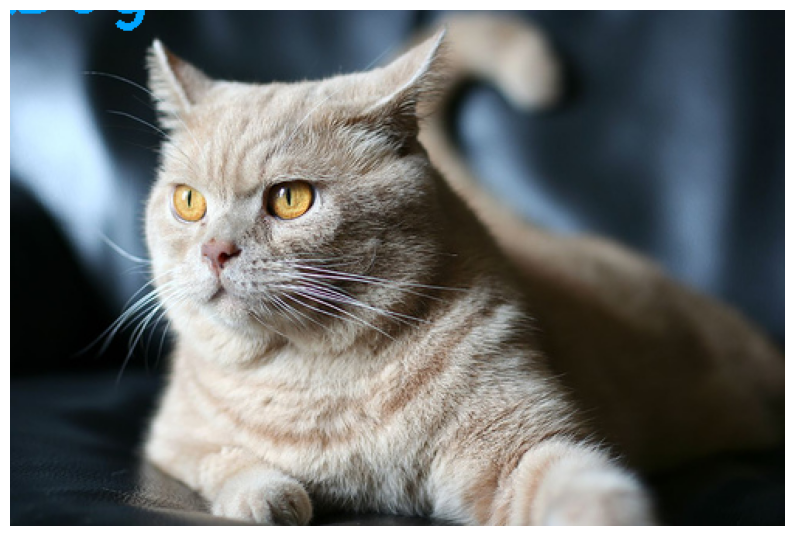

In [21]:
result_image = predict_and_draw('/kaggle/input/cat-dataset/CAT_00/00000001_012.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(result_image)
plt.axis('off')
plt.show()